In [1]:
import numpy as np
import pandas as pd
import os
!pip install yahooquery
import yahooquery
from pandas_datareader import data
!pip install nltk==3.3
from datetime import timedelta, date, datetime

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Get historical stock data

In [35]:
def get_yahoo_dataframe(symbol):
  # Get historical data
  #symbol = 'AAPL'
  ticker = yahooquery.Ticker(symbol)
  df = pd.DataFrame(ticker.history(start='2020-06-01', end='2021-01-29'))
  df=data.DataReader(symbol, 'yahoo', '20200601', '20210129').reset_index()
  df = df[['Date','Adj Close', 'Volume']]
  (df[:10].style.format(dict(Date='{:%d/%m/%Y}'))
  .background_gradient(subset='Volume',cmap='Blues')
  .background_gradient(subset='Adj Close',cmap='Blues')
  )
  #df.Volume.plot()
  #df["Adj Close"].plot()
  dates = pd.DataFrame(pd.date_range('20200601',periods=8*31))
  df.set_index(pd.to_datetime(df['Date']), inplace=True)
  df = df.drop(['Date'], axis=1)
  return df
def process_stock_data(filename, df):
  stock_file = pd.read_csv(filename)
  stock_file.set_index(pd.to_datetime(stock_file['Date']), inplace=True)
  stock_file.drop('Date', axis=1)
  stock_file = stock_file.reindex(df.index, method='bfill')
  #stock_file = stock_file.drop('Date', axis=1)
  #stock_file = stock_file.drop('Period Ending', axis=1)
  return stock_file

# Get news sentiment

In [34]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def get_yahoo_news(symbol):
  start_date = date(2020, 6, 1)
  end_date = date(2021, 1, 29)
  data = []
  run_Dict = []
  ticker = yahooquery.Ticker(symbol)
  for single_date in daterange(start_date, end_date):
      daily_news = ticker.news(start=single_date.strftime("%Y-%m-%d"))
      for article in daily_news:
          #print(article)
          title = article['title']
          if title in run_Dict:
              continue
          else:
              try:
                  run_Dict.append(title)
                  publisher_time = article['provider_publish_time']
                  publisher_time = datetime.utcfromtimestamp(int(publisher_time)).strftime('%Y-%m-%d')
                  data.append([publisher_time, title, article['summary']])
              except KeyError:
                  print("KeyError generated.")
                  continue
          if len(run_Dict) > 30:
              run_Dict = run_Dict[-30:]
  #print(len(data))
  news = pd.DataFrame(data, columns=["date", "Title", "Summary"])
  nltk.download("vader_lexicon")
  sentimentAnalyser = SentimentIntensityAnalyzer()
  news["compound"] = [sentimentAnalyser.polarity_scores(v)['compound'] for v in news["Summary"]]
  news["negative"] = [sentimentAnalyser.polarity_scores(v)['neg'] for v in news["Summary"]]
  news["positive"] = [sentimentAnalyser.polarity_scores(v)['pos'] for v in news["Summary"]]
  news["neutral"] = [sentimentAnalyser.polarity_scores(v)['neu'] for v in news["Summary"]]
  news = news.sort_values(by="date")
  return news
def get_sentiment_from_news(news):
  news_sentiment = news[['date', 'compound']]
  #print(news_sentiment)
  news_sentiment.set_index(pd.to_datetime(news_sentiment['date']), inplace=True)
  #print(news_sentiment[:10])
  news_sentiment = news_sentiment['compound']
  total_sentiment = news_sentiment.groupby('date').agg(lambda x: sum(x))
  total_sentiment = total_sentiment.rename('Total Sentiment')
  nArticles = news_sentiment.groupby('date').count()
  avg_sentiment = total_sentiment/nArticles
  avg_sentiment = avg_sentiment.rename('Avg Sentiment')
  sentiment_data = pd.concat([total_sentiment, avg_sentiment], axis=1)
  sentiment_data = sentiment_data.reindex(df.index, method='ffill')
  return sentiment_data

In [7]:
# df = df.drop('Estimated_Revenue', axis=1)
# df = df.drop('Reported_Revenue', axis=1)
# df = df.drop('Date', axis=1)
# df = df.drop('Estimated_EPS', axis=1)
# # df = df.drop('Reported_EPS', axis=1)
# df = df.drop('Period Ending', axis=1)

# Output prep

In [179]:
def prepare_data_Y_for_ML(df, weekly_or_monthly):
  output = df['Adj Close']
  output.rename('Stock Price')
  advance = df['Adj Close'].shift(10)
  advance = advance.rename('Short Term Advance')
  advance2 = df['Adj Close'].shift(40)
  advance2 = advance2.rename('Mid Term Advance')
  gt = pd.concat([output, advance, advance2], axis=1)
  gt['Short Term Change'] = ((gt['Short Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  gt['Mid Term Change'] = ((gt['Mid Term Advance'] - gt['Adj Close'])/gt['Adj Close'])*100
  #print(gt[9:110])
  #gt['Short Term Change'].plot()
  if weekly_or_monthly == 'weekly':
    Y = gt['Short Term Change'][10:]
    
  elif weekly_or_monthly == 'monthly':
    Y = gt['Mid Term Change'][40:]
    
  else:
    assert 0
  Y=Y.rename("Ground Truth")
  return Y
def prepare_data_X_for_ML(df, weekly_or_monthly):
  df['Weekly Sentiment'] = df['Avg Sentiment'].rolling(5, win_type='triang').sum()
  df['Monthly Sentiment'] = df['Avg Sentiment'].rolling(20, win_type='triang').sum()
  avg_monthly_sentiment = df['Monthly Sentiment'].sum()/len(df['Monthly Sentiment'])
  avg_week = df['Weekly Sentiment'].sum()/len(df['Monthly Sentiment'])
  if weekly_or_monthly == 'weekly':
    X = df[10:]
  elif weekly_or_monthly == 'monthly':
    X = df[40:]
  else:
    assert 0
  ## Ish: Below two lines commented because it was not needed but giving warning: 
  ## ERR:A value is trying to be set on a copy of a slice from a DataFrame.Try using .loc[row_indexer,col_indexer] = value instead
  X['Monthly Sentiment'] = X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
  X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)
  return X

# Test MLP regression

In [141]:
def apply_MLP(X_train,X_test,y_train,y_test):
  sc_X = StandardScaler()
  X_trainscaled=sc_X.fit_transform(X_train)
  X_testscaled=sc_X.transform(X_test)
  reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)
  y_pred=reg.predict(X_testscaled)
  #print("The Score with ", (r2_score(y_test, y_pred)))
  y_pred = pd.DataFrame(y_pred)
  out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)
  out = out.rename(columns={0:"Prediction"})
  #print("The Score with out ", (r2_score(out['Ground Truth'], out['Prediction'])))
  return out

# Combine all data

In [62]:
def get_all_data(symbol):
  ''' Take symbol e.g. 'AAPL' and return a dataframe containing all the useful data for ML'''
  assert isinstance(symbol,str)
  df = get_yahoo_dataframe(symbol)
  stock_file=process_stock_data('/content/gdrive/My Drive/Colab Notebooks/earnings_data/{}.csv'.format(symbol), df)
  #print(stock_file)
  df = df.join(stock_file)
  news=get_yahoo_news(symbol)
  #print(news)
  sentiment_data=get_sentiment_from_news(news)
  #print(sentiment_data)
  df = df.join(sentiment_data)
  
  return df

# Main code

In [11]:
# symbol='AAPL'
# df = get_yahoo_dataframe(symbol)
# df
# stock_file=process_stock_data('/content/gdrive/My Drive/Colab Notebooks/earnings_data/AAPL.csv', df)
# #print(stock_file)
# df = df.join(stock_file)
# news=get_yahoo_news(symbol)
# #print(news)
# sentiment_data=get_sentiment_from_news(news)
# #print(sentiment_data)
# df = df.join(sentiment_data)
# df


In [12]:
# df['Avg Sentiment'].plot()
# df['Total Sentiment'].plot()


In [13]:
# Optional, just because Ish is using Colab: Note: Just run once
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# One time data save to file for quick run-time
It takes ~1.5 min per stock (19 stock ==> ~30min) 

In [71]:
# symlist = ['AAPL', 'ADI', 'AMT', 'AMZN', 'BABA', 'COUP', 'CRM', 'ERIC', 'GOOGL', 'MELI', 'MSFT', 'NVDA', 'OKTA', 'PANW', 'PYPL', 'QCOM', 'SHOP', 'SQ', 'TMUS']
# # symbol=symlist[0]

# for symbol in symlist:
#   df = get_all_data(symbol)
#   df.to_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_prepared_df/{}.csv'.format(symbol))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
KeyError generated.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package v

# Run-time code
Read data from files

In [193]:
symlist = ['AAPL', 'ADI', 'AMT', 'AMZN', 'BABA', 'COUP', 'CRM', 'ERIC', 'GOOGL', 'MELI', 'MSFT', 'NVDA', 'OKTA', 'PANW', 'PYPL', 'QCOM', 'SHOP', 'SQ', 'TMUS']
# symbol=symlist[0]
# Append all stocks along the rows and redefine the index
weekly_or_monthly = 'monthly'
append_df=[] #list of dataframes
append_X=[]
append_Y=[]
for symbol in symlist:
  df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_prepared_df/{}.csv'.format(symbol), index_col=0)
  
  Y=prepare_data_Y_for_ML(df, weekly_or_monthly)
  append_Y.append(Y)
  X=prepare_data_X_for_ML(df, weekly_or_monthly)
  X.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
  append_X.append(X)
  #print(df.shape)
  #df=df.drop(['Date','Estimated_Revenue','Reported_Revenue','Estimated_EPS','Reported_EPS','Period Ending'],axis=1)
  append_df.append(df)
df2=pd.concat(append_df)
df2.shape

Xall=pd.concat(append_X)
Yall=pd.concat(append_Y)
Xall

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

,Surprise_EPS,Total Sentiment,Avg Sentiment,Weekly Sentiment,Monthly Sentiment
Date,,,,,
2020-07-28,0.12,1.8570,0.309500,0.086756,0.456567
2020-07-29,0.12,1.1520,0.144000,0.557567,0.278442
2020-07-30,0.14,0.6279,0.021652,0.615573,0.114692
2020-07-31,0.14,3.0413,0.132230,0.495022,0.030387
2020-08-03,0.14,3.0413,0.132230,0.353049,0.010635
...,...,...,...,...,...
2021-01-25,0.66,0.7964,0.796400,0.956133,1.949876
2021-01-26,0.66,1.0743,0.358100,1.242300,2.002532
2021-01-27,0.66,0.7270,0.363500,1.452300,2.119681


In [194]:
# Train on all  data
X_train,X_test,y_train,y_test = train_test_split(Xall,Yall,test_size=0.25,random_state=0)
out=apply_MLP(X_train,X_test,y_train,y_test)
r2score_all=r2_score(out['Ground Truth'], out['Prediction'])
#print(out)
#print("The Score with ", (r2_score(out['Ground Truth'], out['Prediction'])))

The Score with  0.2683238866675033
The Score with out  0.2683238866675033


In [195]:
#Train individually 
r2score_list = []
for symbol in symlist:
  df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yahoo_prepared_df/{}.csv'.format(symbol), index_col=0)
  
  Y=prepare_data_Y_for_ML(df, weekly_or_monthly)
  X=prepare_data_X_for_ML(df, weekly_or_monthly)
  X.drop(['Adj Close', 'Volume'], axis=1, inplace=True)
  #X=X.drop(['Adj Close'],axis=1)
  X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)
  out=apply_MLP(X_train,X_test,y_train,y_test)
  r2score_list.append(r2_score(out['Ground Truth'], out['Prediction']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

The Score with  0.2984408317069317
The Score with out  0.2984408317069317


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.6460826945781881
The Score with out  0.6460826945781881


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  -0.31977819229908455
The Score with out  -0.31977819229908455


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.3711644696773623
The Score with out  0.3711644696773623


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.7395927622894709
The Score with out  0.7395927622894709


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.18093124993558196
The Score with out  0.18093124993558196


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.8559698980676964
The Score with out  0.8559698980676964


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.5844164816616896
The Score with out  0.5844164816616896


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.5392807454176178
The Score with out  0.5392807454176178


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.6829470189691832
The Score with out  0.6829470189691832


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  -0.1111217518817893
The Score with out  -0.1111217518817893


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.7887799687940527
The Score with out  0.7887799687940527


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.2987108943794262
The Score with out  0.2987108943794262


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.8170181133487218
The Score with out  0.8170181133487218


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  -0.41397664995308436
The Score with out  -0.41397664995308436


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  -0.2977279241590933
The Score with out  -0.2977279241590933


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.5014657687855704
The Score with out  0.5014657687855704


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pand

The Score with  0.5710236639266885
The Score with out  0.5710236639266885
The Score with  -0.6897275488642387
The Score with out  -0.6897275488642387


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## Plot and analysis

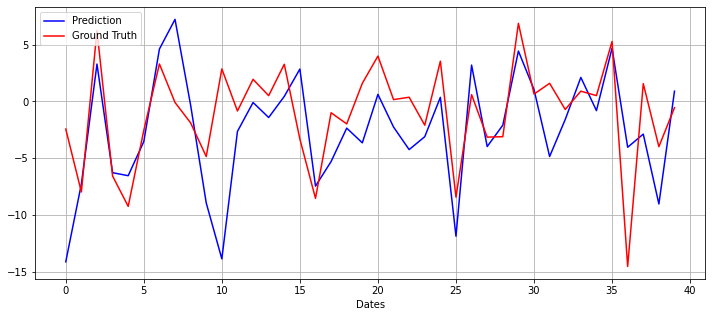

In [184]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()


Text(0.5, 1.0, 'MLP regression on monthly basis')

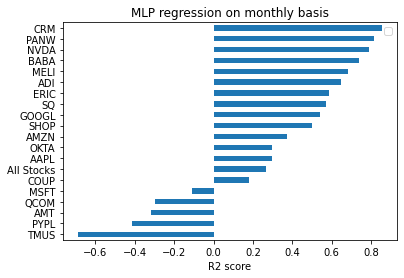

In [196]:
symlist
r2score_list
df_r2 = pd.DataFrame({'r2':r2score_list}, index=symlist)
df_r2=df_r2.append(pd.DataFrame({'r2':r2score_all}, index=['All Stocks']))
df_r2.sort_values(by='r2',axis=0,inplace=True,ascending=True)
ax=df_r2.plot.barh()
ax.set_xlabel('R2 score')
ax.legend('')
mytitle='MLP regression on ' +weekly_or_monthly + ' basis'
mytitle
ax.set_title(mytitle)
# fig, ax = plt.subplots()
# y_pos=np.arange(len(symlist))
# ax.barh(y_pos, r2score_list)
# plt.show()

In [17]:
abcd # Don't run code below

# Test SVM (ToDo: One hot coding and SVM)

Date
2020-06-15    0.0
2020-06-16    0.0
2020-06-17    0.0
2020-06-18    0.0
2020-06-19    0.0
             ... 
2021-01-25    0.0
2021-01-26    0.0
2021-01-27    0.0
2021-01-28    0.0
2021-01-29    0.0
Name: Short Term Change, Length: 159, dtype: float64


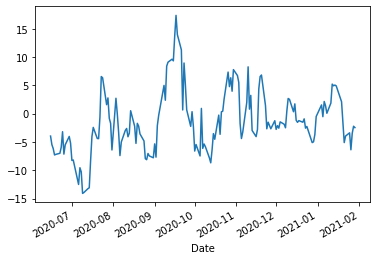

In [18]:
# One hot encoding
Y.plot()
for i,yi in enumerate(Y):
  if yi<-2:
    Y[i] =0
  elif yi<2:
    Y[i]=1
  else:
    Y[i]=2


#Y[0]=1
print(Y)

#print(Y)

In [19]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train, Y_train)
clf.predict(X_test)

NameError: ignored

In [ ]:
X = df[40:]
X['Monthly Sentiment'] =  X['Monthly Sentiment'].fillna(avg_monthly_sentiment)
X['Weekly Sentiment'] = X['Weekly Sentiment'].fillna(avg_week)

In [ ]:
Y = gt['Mid Term Change'][40:]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0)

In [ ]:
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [ ]:
reg = MLPRegressor(hidden_layer_sizes=(5,15,5),activation="relu" ,random_state=1, max_iter=2000).fit(X_trainscaled, y_train)

In [ ]:
y_pred=reg.predict(X_testscaled)
print("The Score with ", (r2_score(y_pred, y_test)))

In [ ]:
y_pred = pd.DataFrame(y_pred)
out = pd.concat([y_test.reset_index(drop=True),y_pred.reset_index(drop=True)], axis=1)

In [ ]:
out = out.rename(columns={0:"Prediction", "Mid Term Change":"Ground Truth"})

In [ ]:
out

In [ ]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')

ax1 = out["Prediction"].plot(color='blue', grid=True)
ax2 = out["Ground Truth"].plot(color='red', grid=True)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1, l1, loc=2)
plt.show()
